# Photosynthesis

Understanding photosynthesis through code.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Defining input variables

Sidenote: why is there no easy way to keep track of units in python? Like m/s, umol/m^2/s, and so on?

Units should be part of the datatype. Looks like `astropy` is one library that supports this.

In [17]:
from typing import Tuple
def quadratic(a: float, b: float, c: float) -> Tuple[float, float]:
    """
    Finds the smaller root of a quadratic equation of the form ax^2 + bx + c = 0.

    :param a: Coefficient of x^2
    :param b: Coefficient of x
    :param c: Constant term
    :return: Smaller root of the quadratic equation
    """
    discriminant = b**2 - 4*a*c
    if discriminant < 0:
        raise ValueError("Quadratic equation has no real roots")
    elif discriminant == 0:
        return -b / (2*a), -b / (2*a)
    else:
        root1 = (-b - discriminant**0.5) / (2*a)
        root2 = (-b + discriminant**0.5) / (2*a)
        return root1, root2

In [18]:
def smaller_root(a, b, c):
    r1, r2 = quadratic(a, b, c)
    return min(r1, r2)

In [19]:
# Electron transport rate
# par = photosynthetically active radiation (W / m^2)

def electron_transport_rate(par_z: float):
    theta_psii = 0.7 # curve fitting parameter
    phi_psii = 0.85 # quantum yield of PSII
    J_max = 200 # (sus) from ChatGPT in umol electron / m^2 / s
    
    I_psii = 0.5 * phi_psii * 4.6 * par_z

    a = theta_psii
    b = - (I_psii + J_max)
    c = I_psii * J_max
    r = smaller_root(a, b, c)

    return r

    

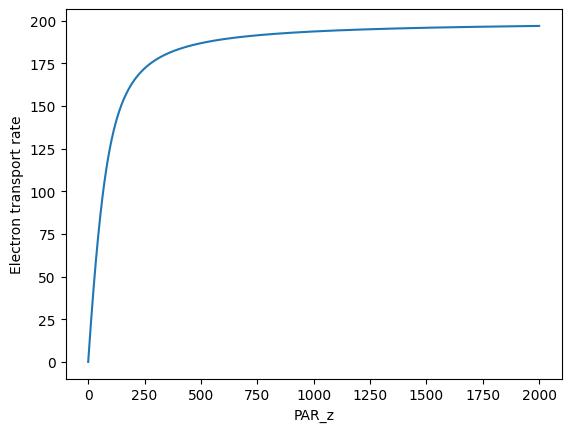

In [9]:
x = np.linspace(0, 2000, 1000)
y = [electron_transport_rate(par_z) for par_z in x]

# Plot the data
plt.plot(x, y)
plt.xlabel('PAR_z')
plt.ylabel('Electron transport rate')
plt.show()

In [32]:
# These variables are all constants

boundary_conductance = 500 
c_air = 40 
o_air = 21000
leaf_maintenance_respiration = 6
par_z = 500
relative_humidity = 0.40

p_atm = 121000

co2_compensation_point = 20 # (check back on this)
kc = 25 # (definitely check back on these)
ko = 500

medlynslope = 6
medlynintercept = 100

vcmax = 50 # maximum rate of carboxylation (umol / m^2 / s)

tpu_z = 0.167 * vcmax # Triose phosphate utilization rate is based on carboxylation rate

# Co-limiting parameters
theta_cj = 0.98
theta_ip = 0.95


## Internal partial pressure of CO2

In [13]:
def co_limit(A_c: float, A_j: float, A_p: float, theta_cj: float, theta_ip: float) -> float:
    A_tot = smaller_root(theta_cj, -(A_c + A_j), A_c * A_j)
    A_tot = smaller_root(theta_ip, -(A_tot + A_p), A_tot * A_p)
    return A_tot

In [37]:
def ci_func(ci, je):
    # Calculate A_c, A_j, A_p (assuming C3)
    A_c = 2000
    # A_c = vcmax * max(ci - co2_compensation_point, 0) / (ci + kc * (1 + o_air / ko))
    A_j = je * max(ci - co2_compensation_point, 0) / (4 * ci + 8 * co2_compensation_point)
    A_p = 3 * tpu_z

    print(f"A_c: {A_c} umol CO2 /m^2/s")
    print(f"A_j: {A_j} umol CO2 /m^2/s")
    print(f"A_p: {A_p} umol CO2 /m^2/s")



    # Colimit these values for gross photosynthesis
    A_g = co_limit(A_c, A_j, A_p, theta_cj, theta_ip)    
    print(f"Gross photosynthesis: {A_g} umol CO2 /m^2/s")

    # Subtract lmr to get to net photosynthesis (TODO: subtract lmr)
    A_n = A_g
    # A_n = A_g - leaf_maintenance_respiration
    print(f"Net photosynthesis: {A_n} umol CO2 /m^2/s")


    # Calculate stomatal conductance (gs_mol):
    c_surface = c_air - 1.4 / boundary_conductance * A_n * p_atm
    term = 1.6 * A_n / (c_surface / p_atm * 1e6)
    a = 1.0
    b = - (2.0 * (medlynintercept * 1e-6 + term) + (medlynslope * term) ** 2 / (boundary_conductance * 1e-6 * relative_humidity))
    c = medlynintercept**2 * 1e-12 + (2.0 * medlynintercept * 1e-6 + term * (1.0 - medlynslope**2 / relative_humidity)) * term
    r1, r2 = quadratic(a, b, c)
    gs_mol = max(r1, r2) * 1e6


    # Derive new estimate for ci
    new_ci = c_air - (1.4 / boundary_conductance + 1.6 / gs_mol) * p_atm * A_n
    fval = ci - new_ci
    print(fval)

    return A_n, gs_mol, fval
    

A_c: 2000 umol CO2 /m^2/s
A_j: 14.633722055315499 umol CO2 /m^2/s
A_p: 25.049999999999997 umol CO2 /m^2/s
Gross photosynthesis: 13.787613407915023 umol CO2 /m^2/s
Net photosynthesis: 13.787613407915023 umol CO2 /m^2/s
5076.22441364858
A_c: 2000 umol CO2 /m^2/s
A_j: 15.224876584453787 umol CO2 /m^2/s
A_p: 25.049999999999997 umol CO2 /m^2/s
Gross photosynthesis: 14.276595539816192 umol CO2 /m^2/s
Net photosynthesis: 14.276595539816192 umol CO2 /m^2/s
5243.514328486685
A_c: 2000 umol CO2 /m^2/s
A_j: 15.80365682868179 umol CO2 /m^2/s
A_p: 25.049999999999997 umol CO2 /m^2/s
Gross photosynthesis: 14.745995221263659 umol CO2 /m^2/s
Net photosynthesis: 14.745995221263659 umol CO2 /m^2/s
5404.104728518447
A_c: 2000 umol CO2 /m^2/s
A_j: 16.37007951365357 umol CO2 /m^2/s
A_p: 25.049999999999997 umol CO2 /m^2/s
Gross photosynthesis: 15.195748344354252 umol CO2 /m^2/s
Net photosynthesis: 15.195748344354252 umol CO2 /m^2/s
5557.973679771234
A_c: 2000 umol CO2 /m^2/s
A_j: 16.924177482229926 umol CO2 

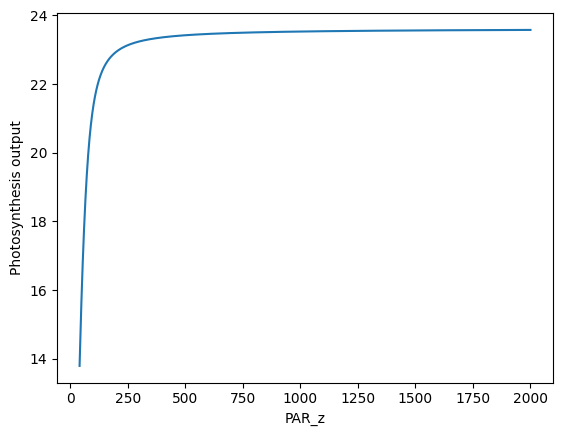

In [38]:
ci = 400

def photosynthesis_output(par_z: float):
    je = electron_transport_rate(par_z)

    # TODO: Given je, find optimal ci by rootfinding.

    return ci_func(ci, je)[0]

# Graph a light response curve
x = np.linspace(40, 2000, 1000)
y = [photosynthesis_output(par_z) for par_z in x]

plt.plot(x, y)
plt.xlabel('PAR_z')
plt.ylabel('Photosynthesis output')
plt.show()